In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clicks_df = pd.read_csv('/content/drive/My Drive/Data mining/stud_dates_click.csv')
clicks_df

,code_module,code_presentation,id_student,final_result,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
0,AAA,2013J,11391,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,49.0,127.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,20.0,0.0,...,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,78.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAA,2013J,28400,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,9.0,81.0,13.0,4.0,6.0,0.0,32.0,0.0,48.0,16.0,0.0,0.0,29.0,9.0,73.0,7.0,59.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AAA,2013J,30268,Withdrawn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,3.0,0.0,0.0,0.0,0.0,11.0,48.0,29.0,0.0,0.0,0.0,0.0,54.0,37.0,16.0,0.0,0.0,33.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAA,2013J,31604,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,69.0,0.0,0.0,27.0,0.0,1.0,0.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,41.0,19.0,...,26.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,30.0,6.0,25.0,10.0,30.0,4.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,AAA,2013J,32885,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,13.0,6.0,7.0,21.0,74.0,0.0,21.0,75.0,0.0,0.0,17.0,11.0,11.0,8.0,0.0,14.0,0.0,0.0,0.0,40.0,...,0.0,5.0,0.0,0.0,7.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,Fail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32589,GGG,2014J,2645731,Distinction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32590,GGG,2014J,2648187,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32591,GGG,2014J,2679821,Withdrawn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
stud_df = pd.read_csv('/content/drive/My Drive/Data mining/studentInfo.csv')
stud_df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


In [ ]:
# merge three table for further processing
data = pd.merge(stud_df, clicks_df, on=['code_module', 'code_presentation', 'id_student', 'final_result'], how='inner')
data

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,49.0,127.0,4.0,...,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,78.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,9.0,81.0,13.0,4.0,6.0,0.0,32.0,0.0,48.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,3.0,0.0,0.0,0.0,0.0,11.0,48.0,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,69.0,0.0,0.0,27.0,0.0,1.0,0.0,12.0,0.0,0.0,22.0,0.0,...,26.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,30.0,6.0,25.0,10.0,30.0,4.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,13.0,6.0,7.0,21.0,74.0,0.0,21.0,75.0,0.0,0.0,17.0,11.0,...,0.0,5.0,0.0,0.0,7.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
# change the label of target
data['final_result'] = data['final_result'].map({'Pass':1, 'Distinction':1, 'Withdrawn':0, 'Fail':0})

# split the data into train and test
dataX = data.drop(columns='final_result')
target = data['final_result']
X, X_test, y, y_test = train_test_split(dataX, target, test_size=0.2, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

In [ ]:
def prepare_data(X, rule='W', week_no=None):
    
    #clicks data
    cols = [str(i) for i in range(-25, 250)]
    X1 = X[cols]
    X1 = X1.T
    X1.index = pd.date_range(start='1/1/2014', periods=275)
    X1 = X1.resample(rule).sum()
    X1 = X1.T
    if week_no:
        X1 = X1.iloc[:, :week_no]
          
    return X1

In [ ]:
print('Train target count:', Counter(y_train))
print('Validation target count: ', Counter(y_val))
print('Test target count:', Counter(y_test))

Train target count: Counter({0: 12389, 1: 11077})
Validation target count:  Counter({0: 1377, 1: 1231})
Test target count: Counter({0: 3442, 1: 3077})


In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv1D, BatchNormalization,AveragePooling1D, Flatten, Add, Multiply, Softmax, LSTM
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential, Model

In [ ]:
def visualize_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.show()

# CNN base model

In [ ]:
# define cnn model
def cnn_model():
    cnn = Sequential()
    cnn.add(Input(shape=(X_train_clicks.shape[1], 1)))
    cnn.add(Conv1D(16, kernel_size=2, activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(AveragePooling1D(2))
    cnn.add(Conv1D(32, kernel_size=2, activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(AveragePooling1D(2))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    cnn.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    cnn.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    cnn.add(Dense(1,  activation='sigmoid'))
    # compile the model
    cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn


# Define ann model
def ann_model():
    ann = Sequential()
    ann.add(Input(shape=(X_train_clicks.shape[1], )))
    ann.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    ann.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    ann.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    ann.add(Dense(1, activation='sigmoid'))
    # compile the model
    ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return ann


# define lstm model
def lstm_model():
    lstm = Sequential()
    lstm.add(LSTM(25, activation='relu', input_shape=(X_train_clicks.shape[1],1), return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
    lstm.add(LSTM(10, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))
    lstm.add(Dense(1, activation='sigmoid'))
    # compile the model
    lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm

# Lets do the early prediction based on every months

In [ ]:
# week vs accuracy
accuracy = {'ann':[], 'cnn':[], 'lstm':[]}

for i in range(12, 41, 4):
    # prepare the data
    X_train_clicks = prepare_data(X_train, week_no=i)
    X_val_clicks = prepare_data(X_val, week_no=i)
    X_test_clicks = prepare_data(X_test, week_no=i)
    
    # change dimension
    X_train_clicks_2 = X_train_clicks.to_numpy().reshape(X_train_clicks.shape[0], X_train_clicks.shape[1], 1)
    X_val_clicks_2 = X_val_clicks.to_numpy().reshape(X_val_clicks.shape[0], X_val_clicks.shape[1], 1)
    X_test_clicks_2 = X_test_clicks.to_numpy().reshape(X_test_clicks.shape[0], X_test_clicks.shape[1], 1)
    
    # call model
    models = {'ann':ann_model(), 'cnn':cnn_model(), 'lstm':lstm_model()}
    for name, model in models.items():
    
        # save model based on validation accuracy
        path = '/content/drive/My Drive/Data mining/model/week_model.h5'
        callbacks = ModelCheckpoint(path, save_best_only=True, save_weights_only=True, mode='max', monitor='val_accuracy', verbose=0)

        # train the model
        if name=='ann':
            model.fit(X_train_clicks, y_train, validation_data=(X_val_clicks, y_val), epochs=20, batch_size=32, verbose=0, callbacks=[callbacks])
        else:
            model.fit(X_train_clicks_2, y_train, validation_data=(X_val_clicks_2, y_val), epochs=20, batch_size=32, verbose=0, callbacks=[callbacks])

        # load the model weight and Test 
        model.load_weights(path)
        if name=='ann':
            predict = model.predict(X_test_clicks)
        else:
            predict = model.predict(X_test_clicks_2)
            
        predict = np.where(predict>0.5, 1, 0)
        accuracy[name].append(accuracy_score(predict, y_test)) 

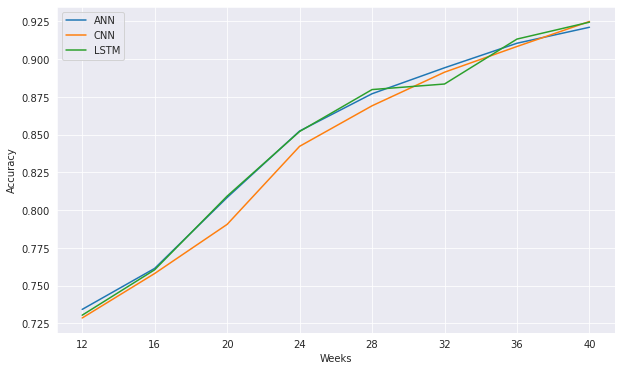

In [ ]:
idx = list(range(12, 41, 4))
plt.figure(figsize=(10, 6))
for name, val in accuracy.items():
    plt.plot(idx, val, label=name.upper())
plt.legend()
plt.xlabel('Weeks')
plt.ylabel('Accuracy')
plt.xticks(idx)
plt.savefig('/content/drive/My Drive/Data mining/early_week_compare.jpg')